# Embedded Topic Model (ETM)

In [1]:
import spacy
import string
import json
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ETM import ETM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Integer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

from preprocessing.clean_text import *

In [3]:
extract_corpus_and_labels_from_directory(base_path = 'data/bbc/', output_path = 'data/input')

num_iters = 15
number_of_calls = 45

Corpus has been saved to data/input/corpus.txt
Labels have been saved to data/input/labels.txt


## Data setup

## Preprocessing


In [4]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation=True,
                             punctuation=string.punctuation,
                             remove_numbers=True,
                             lemmatize= True,
                             stopword_list=CUSTOM_STOPWORDS,
                             min_chars=3,
                             min_words_docs=10,
                             language='english',
                             split=True,
                             verbose=True)

In [5]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists('data/processed/dataset'):
    dataset = preprocessor.preprocess_dataset(documents_path = 'data/input/corpus.txt',labels_path = 'data/input/labels.txt')
    dataset.save('data/processed/dataset')
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder('data/processed/dataset')

In [6]:
dataset.get_metadata()

{'total_documents': 2225,
 'vocabulary_length': 4168,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 10 and higher than 0.85',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 1557,
 'last-validation-doc': 1891}

## Embeddings loading

## ETM model without optimization

In [7]:
N_TOPICS = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

current_device = torch.cuda.current_device()
print(f"Currently using GPU: {current_device}")
print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

Currently using GPU: 0
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [8]:
model = ETM(num_topics= N_TOPICS,  
        num_epochs=100, 
        t_hidden_size=200, 
        rho_size=300,
        embedding_size=300,
        activation='relu', 
        dropout=0.5, 
        lr=5e-3, 
        optimizer='adam', 
        batch_size=64, 
        clip=0.0, 
        wdecay=1.2e-6, 
        bow_norm=1, 
        device=device, 
        train_embeddings=True)
            

In [9]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_v') # Initialize metric

In [10]:
coherence_list_no_opt, topic_diversity_list_no_opt = [], []

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))


  0%|          | 0/15 [00:00<?, ?it/s]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.27 .. Rec_loss: 1261.41 .. NELBO: 1261.68
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.23 .. Rec_loss: 1282.83 .. NELBO: 1283.06
****************************************************************************************************
****************************************************************************************

  7%|▋         | 1/15 [00:08<01:53,  8.10s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.71 .. Rec_loss: 1260.08 .. NELBO: 1260.79
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.61 .. Rec_loss: 1281.55 .. NELBO: 1282.16
****************************************************************************************************
****************************************************************************************

 13%|█▎        | 2/15 [00:13<01:23,  6.46s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.27 .. Rec_loss: 1261.44 .. NELBO: 1261.71
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.23 .. Rec_loss: 1282.89 .. NELBO: 1283.12
****************************************************************************************************
****************************************************************************************

 20%|██        | 3/15 [00:18<01:09,  5.80s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.09 .. Rec_loss: 1261.72 .. NELBO: 1261.81
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.08 .. Rec_loss: 1283.22 .. NELBO: 1283.3
****************************************************************************************************
*****************************************************************************************

 27%|██▋       | 4/15 [00:23<00:58,  5.33s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.31 .. Rec_loss: 1261.88 .. NELBO: 1262.19
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.27 .. Rec_loss: 1283.26 .. NELBO: 1283.53
****************************************************************************************************
****************************************************************************************

 33%|███▎      | 5/15 [00:37<01:25,  8.54s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.11 .. Rec_loss: 1260.98 .. NELBO: 1261.09
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.1 .. Rec_loss: 1282.57 .. NELBO: 1282.67
****************************************************************************************************
*****************************************************************************************

 40%|████      | 6/15 [00:55<01:46, 11.87s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.11 .. Rec_loss: 1260.71 .. NELBO: 1260.82
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.09 .. Rec_loss: 1282.32 .. NELBO: 1282.41
****************************************************************************************************
****************************************************************************************

 47%|████▋     | 7/15 [01:00<01:17,  9.70s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.43 .. Rec_loss: 1260.04 .. NELBO: 1260.47
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.36 .. Rec_loss: 1281.58 .. NELBO: 1281.94
****************************************************************************************************
****************************************************************************************

 53%|█████▎    | 8/15 [01:05<00:56,  8.13s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.07 .. Rec_loss: 1261.93 .. NELBO: 1262.0
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.06 .. Rec_loss: 1283.36 .. NELBO: 1283.42
****************************************************************************************************
*****************************************************************************************

 60%|██████    | 9/15 [01:20<01:02, 10.34s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.17 .. Rec_loss: 1261.94 .. NELBO: 1262.11
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.14 .. Rec_loss: 1283.35 .. NELBO: 1283.49
****************************************************************************************************
****************************************************************************************

 67%|██████▋   | 10/15 [01:39<01:04, 12.81s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.11 .. Rec_loss: 1261.04 .. NELBO: 1261.15
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.1 .. Rec_loss: 1282.6 .. NELBO: 1282.7
****************************************************************************************************
*******************************************************************************************

 73%|███████▎  | 11/15 [01:44<00:42, 10.51s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.22 .. Rec_loss: 1261.02 .. NELBO: 1261.24
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.19 .. Rec_loss: 1282.57 .. NELBO: 1282.76
****************************************************************************************************
****************************************************************************************

 80%|████████  | 12/15 [01:49<00:26,  8.91s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.06 .. Rec_loss: 1261.6 .. NELBO: 1261.66
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.05 .. Rec_loss: 1283.15 .. NELBO: 1283.2
****************************************************************************************************
******************************************************************************************

 87%|████████▋ | 13/15 [01:58<00:17,  8.93s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.17 .. Rec_loss: 1261.08 .. NELBO: 1261.25
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.15 .. Rec_loss: 1282.62 .. NELBO: 1282.77
****************************************************************************************************
****************************************************************************************

 93%|█████████▎| 14/15 [02:03<00:07,  7.77s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=5, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=5, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=5, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.005 .. KL_theta: 0.35 .. Rec_loss: 1261.9 .. NELBO: 1262.25
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.29 .. Rec_loss: 1283.15 .. NELBO: 1283.44
****************************************************************************************************
*****************************************************************************************

100%|██████████| 15/15 [02:08<00:00,  8.54s/it]

Mean coherence:  0.37355404274410114 
Mean topic diversity:  0.38266666666666665


In [11]:
model = ETM()

In [12]:
# Optimization for hyperparameters based on coherence (to be substituted with a combination of ch e td ?)


# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "t_hidden_size": Integer(low= 50, high=300),
                "lr": Real(low=1e-4, high=1e-1)}

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()


In [13]:
# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call=number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs=5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

results = json.load(open("results/test_LDA/result.json",'r'))

Current call:  0
model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=36, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=296, bias=True)
    (1): ReLU()
    (2): Linear(in_features=296, out_features=296, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=296, out_features=36, bias=True)
  (logsigma_q_theta): Linear(in_features=296, out_features=36, bias=True)
)
****************************************************************************************************
Epoch----->1 .. LR: 0.04865612756985289 .. KL_theta: 3.08 .. Rec_loss: 1290.23 .. NELBO: 1293.31
****************************************************************************************************
****************************************************************************************************
VALIDATION .. LR: 0.04865612756985289 .. KL_thet

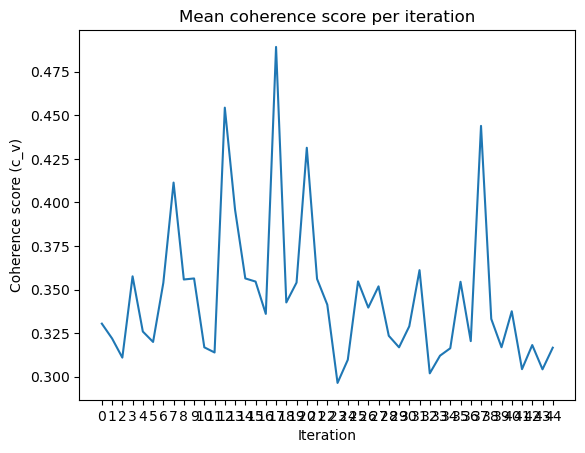

In [14]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Mean coherence score per iteration')

coherences = results['dict_model_runs']['Coherence']

mean_coherences = [np.mean(coherences[key]) for key in coherences.keys()]

plt.plot(mean_coherences)
plt.xticks(range(len(mean_coherences)))
plt.show()


In [15]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


0.5335931404870303


In [16]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
t_hidden_size = results["x_iters"]["t_hidden_size"][max_index]
lr = results["x_iters"]["lr"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal encoder hidden size: ", t_hidden_size)
print("Optimal learning rate: ", lr)

dict_keys(['lr', 'num_topics', 't_hidden_size'])
Optimal number of topics:  6
Optimal encoder hidden size:  193
Optimal learning rate:  0.0019815844887290284


In [17]:
model = ETM(num_topics = num_topics,  
        num_epochs = 100, 
        t_hidden_size = t_hidden_size, 
        rho_size = 300,
        embedding_size = 300,
        activation = 'relu', 
        dropout = 0.5, 
        lr = lr, 
        optimizer = 'adam', 
        batch_size = 64, 
        clip = 0.0, 
        wdecay = 1.2e-6, 
        bow_norm = 1, 
        device = device, 
        train_embeddings = True)
            

In [18]:
coherence_list, topic_diversity_list, outputs = [], [], []

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset, top_words=20)
  outputs.append(output)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

  0%|          | 0/15 [00:00<?, ?it/s]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.01 .. Rec_loss: 1303.87 .. NELBO: 1303.88
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.01 .. Rec_loss: 1326.72 .. NELBO: 1326.73
****************************************************************************************************
********************************************************

  7%|▋         | 1/15 [00:13<03:13, 13.83s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.17 .. Rec_loss: 1302.78 .. NELBO: 1302.95
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.31 .. Rec_loss: 1325.24 .. NELBO: 1325.55
****************************************************************************************************
********************************************************

 13%|█▎        | 2/15 [00:37<04:18, 19.88s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.03 .. Rec_loss: 1303.54 .. NELBO: 1303.57
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.04 .. Rec_loss: 1326.3 .. NELBO: 1326.34
****************************************************************************************************
*********************************************************

 20%|██        | 3/15 [00:54<03:41, 18.49s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.12 .. Rec_loss: 1302.27 .. NELBO: 1302.39
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.27 .. Rec_loss: 1324.66 .. NELBO: 1324.93
****************************************************************************************************
********************************************************

 27%|██▋       | 4/15 [01:00<02:26, 13.32s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.04 .. Rec_loss: 1303.6 .. NELBO: 1303.64
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.06 .. Rec_loss: 1326.34 .. NELBO: 1326.4
****************************************************************************************************
**********************************************************

 33%|███▎      | 5/15 [01:13<02:13, 13.34s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.09 .. Rec_loss: 1303.4 .. NELBO: 1303.49
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.15 .. Rec_loss: 1326.1 .. NELBO: 1326.25
****************************************************************************************************
**********************************************************

 40%|████      | 6/15 [01:18<01:34, 10.51s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.11 .. Rec_loss: 1303.05 .. NELBO: 1303.16
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.21 .. Rec_loss: 1325.58 .. NELBO: 1325.79
****************************************************************************************************
********************************************************

 47%|████▋     | 7/15 [01:45<02:06, 15.86s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.09 .. Rec_loss: 1303.17 .. NELBO: 1303.26
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.15 .. Rec_loss: 1325.8 .. NELBO: 1325.95
****************************************************************************************************
*********************************************************

 53%|█████▎    | 8/15 [01:50<01:26, 12.42s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.08 .. Rec_loss: 1303.63 .. NELBO: 1303.71
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.17 .. Rec_loss: 1326.33 .. NELBO: 1326.5
****************************************************************************************************
*********************************************************

 60%|██████    | 9/15 [01:55<01:00, 10.07s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.08 .. Rec_loss: 1303.49 .. NELBO: 1303.57
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.12 .. Rec_loss: 1326.16 .. NELBO: 1326.28
****************************************************************************************************
********************************************************

 67%|██████▋   | 10/15 [02:00<00:42,  8.49s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.07 .. Rec_loss: 1303.1 .. NELBO: 1303.17
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.09 .. Rec_loss: 1325.8 .. NELBO: 1325.89
****************************************************************************************************
**********************************************************

 73%|███████▎  | 11/15 [02:16<00:43, 10.93s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.08 .. Rec_loss: 1303.67 .. NELBO: 1303.75
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.14 .. Rec_loss: 1326.42 .. NELBO: 1326.56
****************************************************************************************************
********************************************************

 80%|████████  | 12/15 [02:22<00:27,  9.24s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.06 .. Rec_loss: 1302.85 .. NELBO: 1302.91
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.09 .. Rec_loss: 1325.44 .. NELBO: 1325.53
****************************************************************************************************
********************************************************

 87%|████████▋ | 13/15 [02:49<00:29, 14.60s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.04 .. Rec_loss: 1303.63 .. NELBO: 1303.67
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.07 .. Rec_loss: 1326.38 .. NELBO: 1326.45
****************************************************************************************************
********************************************************

 93%|█████████▎| 14/15 [03:07<00:15, 15.77s/it]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=4168, bias=False)
  (alphas): Linear(in_features=300, out_features=6, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=4168, out_features=193, bias=True)
    (1): ReLU()
    (2): Linear(in_features=193, out_features=193, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=193, out_features=6, bias=True)
  (logsigma_q_theta): Linear(in_features=193, out_features=6, bias=True)
)
Epoch: 1 .. batch: 20/25 .. LR: 0.0019815844887290284 .. KL_theta: 0.08 .. Rec_loss: 1302.92 .. NELBO: 1303.0
****************************************************************************************************
Epoch----->1 .. LR: 0.0019815844887290284 .. KL_theta: 0.12 .. Rec_loss: 1325.52 .. NELBO: 1325.64
****************************************************************************************************
*********************************************************

100%|██████████| 15/15 [03:19<00:00, 13.32s/it]

Mean coherence:  0.455586319837519 
Mean topic diversity:  0.5166666666666667


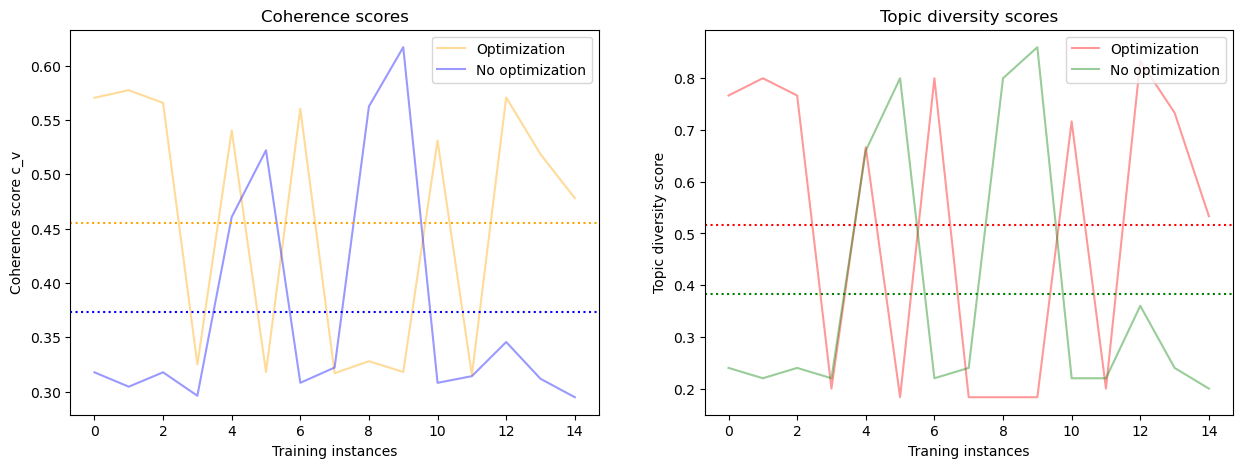

In [19]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt). Both plots also show the mean values and the variance!
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score c_v")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()

In [20]:
# Extract the best output from the outputs list according to a linear combination of the coherence and topic diversity scores

best_output = outputs[np.argmax([0.7*coherence_list[i] + 0.3*topic_diversity_list[i] for i in range(len(coherence_list))])]


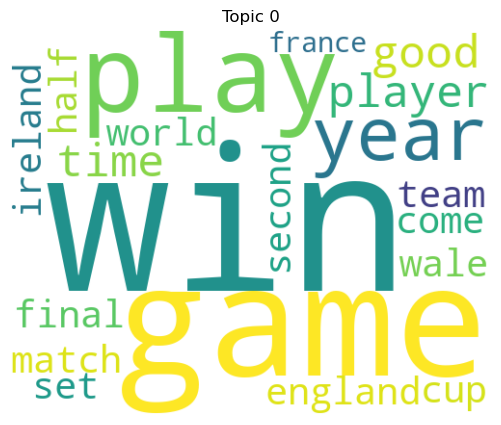

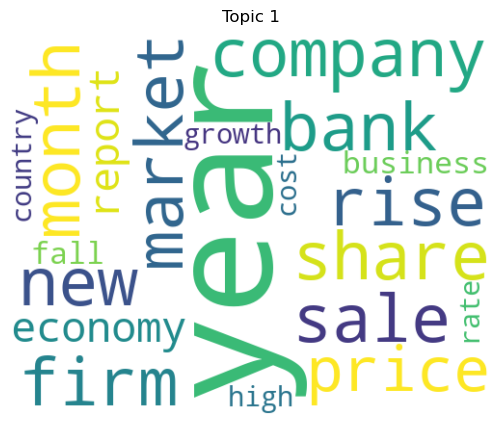

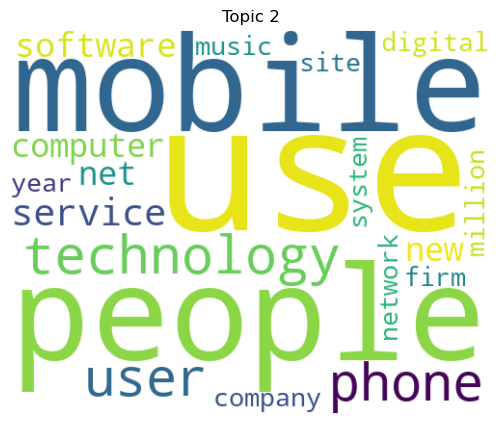

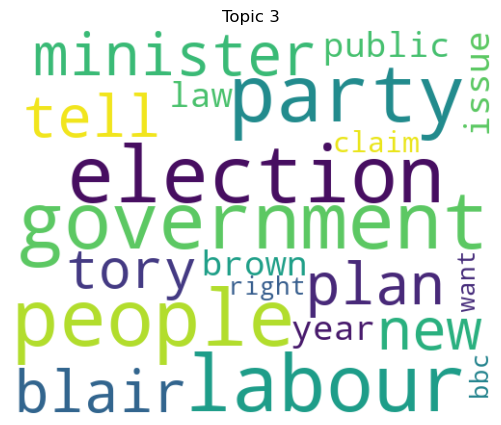

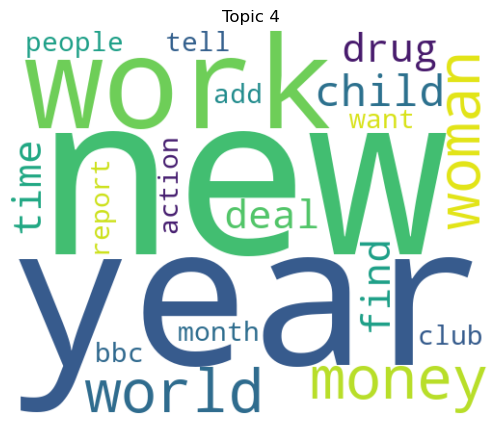

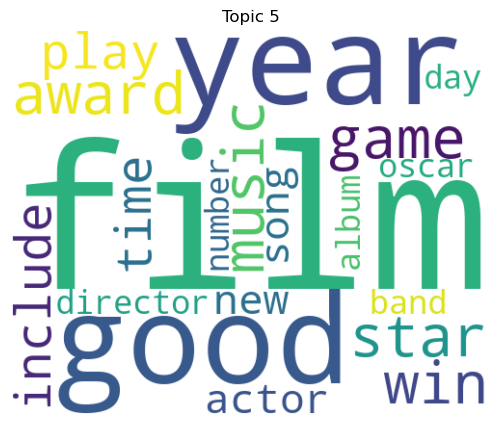

In [21]:
topics = best_output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()

In [23]:
topic_word_matrix = best_output['topic-word-matrix']
words = best_output['topics'] # List of all words in the vocabulary


# Number of words to display 
top_n_words = 10

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = words[i]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10,) and arg 3 with shape (20,).